# Option Pricing: Black-Scholes, Heston, and Merton
## Overall Objective: Understand and compare three fundamental option pricing models.

<span style="color:gray; opacity: 0.5;">**1. Black-Scholes:** The benchmark model assuming constant volatility.</span>  
    <span style="color:gray; opacity: 0.5;">_Provides a great baseline and is computationally efficient, but assumes constant $\sigma$ which is unrealistic for modern markets._</span>

<div style="border-left: 4px solid #2196F3; padding-left: 15px;">

**2. Merton Jump: Adds "jumps" to the asset price to model market shocks.**   
_Captures "Fat Tails" and sudden crashes via Poisson jumps._
</div>

<span style="color:gray; opacity: 0.5;">**3. Heston:** Adds stochastic volatility (volatility clustering and mean reversion).</span>  
    <span style="color:gray; opacity: 0.5;">_Captures the "Smirk" or "Skew" via stochastic vol—essential for pricing OTM puts accurately._</span>


# Model 2: The Merton Jump Diffusion Model (MJD)
## Objective: Capturing Market Shocks and "Fat Tails"

The Black-Scholes model assumes that stock prices follow a continuous, smooth path (Geometric Brownian Motion). However, in reality, markets experience sudden, discontinuous shocks—earnings surprises, macroeconomic news, or overnight crashes. 

Robert Merton (1976) extended the Black-Scholes model by adding a **Poisson Jump Process** to the continuous diffusion. 

### The Mathematical Intuition
The asset price dynamics under MJD are described by:
$$\frac{dS_t}{S_t} = (\mu - \lambda k) dt + \sigma dW_t + (J_t - 1) dN_t$$

Where:
1. **The Continuous Part ($\sigma dW_t$):** The standard Black-Scholes daily noise (Brownian motion).
2. **The Jump Counter ($dN_t$):** A Poisson process. Most days it is 0. Occasionally, it "fires" and equals 1. The frequency of jumps is governed by $\lambda$ (expected jumps per year).
3. **The Jump Size ($J_t$):** When a jump occurs, how big is it? Merton assumes the jump sizes are log-normally distributed, with a mean jump size ($\mu_j$) and a jump variance ($\delta^2$).

By adding these random jumps, the Merton model naturally creates the "Fat Tails" and "Left Skew" seen in real-world S&P 500 return distributions. Let's visualize this difference.

## Imports and Setup

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as si
from scipy.integrate import quad
import seaborn as sns

# Set plotting style
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Global Parameters (Toggles)
S0 = 100.0    # Spot Price
K_list = np.linspace(80, 120, 50) # Range of Strikes for plotting
T = 1.0       # Time to Maturity (1 year)
r = 0.05      # Risk-free rate
q = 0.0       # Dividend yield

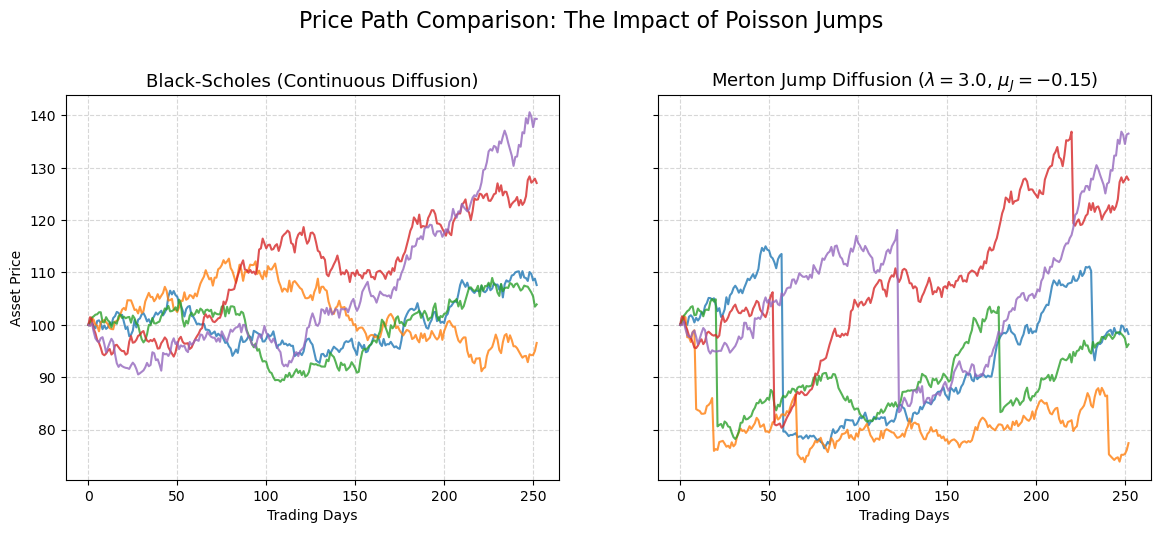

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# --- Simulation Parameters ---
S0 = 100       # Initial Stock Price
T = 1.0        # Time to maturity (1 Year)
r = 0.05       # Risk-free rate
sigma = 0.15   # Continuous Volatility (15%)
steps = 252    # Trading days in a year
n_paths = 5    # Number of paths to visualize
dt = T / steps

# --- Merton Jump Parameters ---
lam = 3.0      # Expect 3 jumps per year
mu_j = -0.15   # Average jump size is a 15% drop (Negative skew)
delta = 0.10   # Volatility of the jump size

# Random seeds for reproducibility
np.random.seed(42)

# 1. Generate Random Variables
Z = np.random.standard_normal((steps, n_paths)) # Brownian Motion
N = np.random.poisson(lam * dt, (steps, n_paths)) # Poisson Jump Counter
J = np.random.normal(mu_j, delta, (steps, n_paths)) # Log-Normal Jump Sizes

# 2. Calculate Returns
# Black-Scholes Returns
ret_bs = (r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z

# Merton Returns (Must subtract the compensator to prevent arbitrage)
k = np.exp(mu_j + 0.5 * delta**2) - 1
ret_merton = (r - lam * k - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z + N * J

# 3. Build Price Paths
S_bs = np.zeros((steps + 1, n_paths))
S_merton = np.zeros((steps + 1, n_paths))
S_bs[0], S_merton[0] = S0, S0

for t in range(1, steps + 1):
    S_bs[t] = S_bs[t-1] * np.exp(ret_bs[t-1])
    S_merton[t] = S_merton[t-1] * np.exp(ret_merton[t-1])

# --- Plot the Paths ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Plot Black-Scholes
axes[0].plot(S_bs, alpha=0.8, linewidth=1.5)
axes[0].set_title("Black-Scholes (Continuous Diffusion)", fontsize=13)
axes[0].set_ylabel("Asset Price")
axes[0].set_xlabel("Trading Days")
axes[0].grid(True, linestyle='--', alpha=0.5)

# Plot Merton
axes[1].plot(S_merton, alpha=0.8, linewidth=1.5)
axes[1].set_title(f"Merton Jump Diffusion ($\lambda={lam}$, $\mu_J={mu_j}$)", fontsize=13)
axes[1].set_xlabel("Trading Days")
axes[1].grid(True, linestyle='--', alpha=0.5)

plt.suptitle("Price Path Comparison: The Impact of Poisson Jumps", fontsize=16, y=1.05)
plt.show()

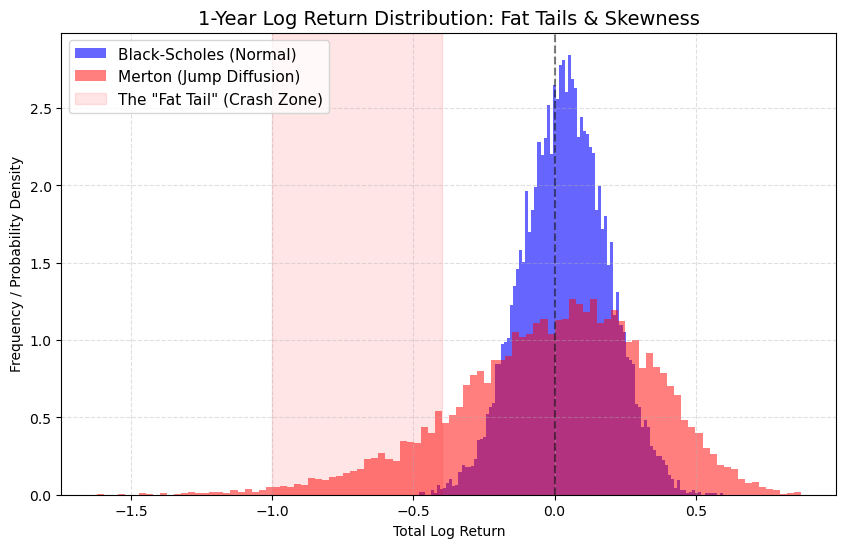

In [3]:
# --- Simulate 10,000 paths to analyze the Distribution ---
n_sims = 10000

Z_dist = np.random.standard_normal((steps, n_sims))
N_dist = np.random.poisson(lam * dt, (steps, n_sims))
J_dist = np.random.normal(mu_j, delta, (steps, n_sims))

ret_bs_dist = (r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z_dist
ret_merton_dist = (r - lam * k - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z_dist + N_dist * J_dist

# Sum the daily log returns to get the 1-Year Total Return
total_ret_bs = np.sum(ret_bs_dist, axis=0)
total_ret_merton = np.sum(ret_merton_dist, axis=0)

# --- Plot the Return Distributions ---
plt.figure(figsize=(10, 6))

# Plot Histograms
plt.hist(total_ret_bs, bins=100, alpha=0.6, density=True, color='blue', label='Black-Scholes (Normal)')
plt.hist(total_ret_merton, bins=100, alpha=0.5, density=True, color='red', label='Merton (Jump Diffusion)')

plt.title("1-Year Log Return Distribution: Fat Tails & Skewness", fontsize=14)
plt.xlabel("Total Log Return")
plt.ylabel("Frequency / Probability Density")
plt.axvline(0, color='black', linestyle='--', alpha=0.5)

# Highlight the "Crash" zone (Left Tail)
plt.axvspan(-1.0, -0.4, color='red', alpha=0.1, label='The "Fat Tail" (Crash Zone)')

plt.legend(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

Calculating Theoretical Merton Prices and Implied Volatilities...
Note: Reversing prices back into IV requires heavy root-finding!


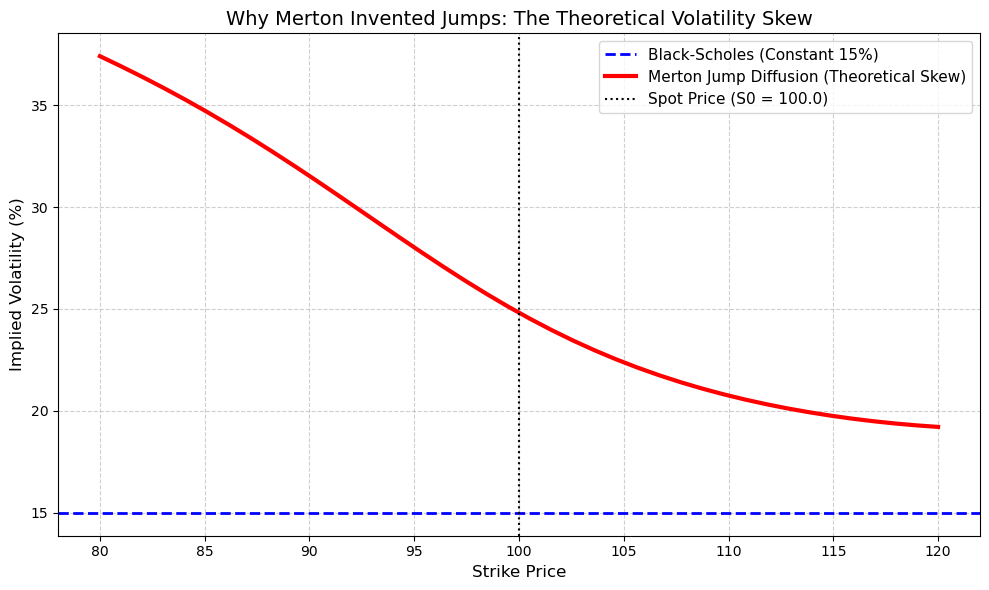

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import warnings

# Import our math engine tools
from quant_math_engine import merton_jump_call, implied_volatility

# --- 1. Define Theoretical Market Parameters ---
S0 = 100.0
T = 0.25      # 3 months to expiration (Jumps are highly visible in short-term options)
r = 0.05
q = 0.0

# Define a range of strikes from Deep OTM Puts (80) to Deep OTM Calls (120)
theoretical_strikes = np.linspace(80, 120, 40)

# --- 2. Define Baseline vs Jump Parameters ---
# Black-Scholes assumes a flat, constant 15% volatility
sigma_baseline = 0.15 

# Merton assumes the same 15% baseline, PLUS the risk of an overnight crash
lam = 1.0     # 1 jump per year
mu_j = -0.20  # The average jump is a 20% market crash
delta = 0.15  # Volatility of the jump size

print("Calculating Theoretical Merton Prices and Implied Volatilities...")
print("Note: Reversing prices back into IV requires heavy root-finding!")

# --- 3. Calculate Prices and Convert to IV ---
merton_ivs = []

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for K in theoretical_strikes:
        # Step A: Get the theoretical Merton Price
        m_price = merton_jump_call(S0, K, T, r, q, sigma_baseline, lam, mu_j, delta)
        
        # Step B: Force that price through a Black-Scholes root-finder to extract the IV
        m_iv = implied_volatility(m_price, S0, K, T, r, q)
        merton_ivs.append(m_iv)

merton_ivs = np.array(merton_ivs) * 100 # Convert to percentage

# --- 4. Plot the Theoretical Disconnect ---
plt.figure(figsize=(10, 6))

# Plot the flat Black-Scholes assumption
plt.axhline(sigma_baseline * 100, color='blue', linestyle='--', linewidth=2, 
            label=f'Black-Scholes (Constant {sigma_baseline*100:.0f}%)')

# Plot the resulting Merton Volatility Smile
plt.plot(theoretical_strikes, merton_ivs, color='red', linewidth=3, 
         label='Merton Jump Diffusion (Theoretical Skew)')

# Formatting
plt.axvline(S0, color='black', linestyle=':', label=f'Spot Price (S0 = {S0})')
plt.title("Why Merton Invented Jumps: The Theoretical Volatility Skew", fontsize=14)
plt.xlabel("Strike Price", fontsize=12)
plt.ylabel("Implied Volatility (%)", fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()